<a href="https://colab.research.google.com/github/nelrob/movie-ranking-prediction/blob/main/Movie_Ranking_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 2.1 MB/s eta 0:00:00


In [2]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import tempfile

import numpy as np
import tensorflow as tf
 
from typing import Dict, Text
import pprint

In [3]:
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.11.0


# Data Pre-processing

In [4]:
ratings = tfds.load("movielens/100k-ratings", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteDK9KT3/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
ratings_array = []

for rating in ratings:
    # Extracts values from the Tensor objects
    movie_title = rating['movie_title'].numpy()
    movie_title = movie_title.decode('utf-8')
    
    user_id = int(rating['user_id'].numpy())
    user_rating = rating['user_rating'].numpy()
    
    ratings_array.append([movie_title, user_id, user_rating])

In [8]:
# ratings_array

In [9]:
import pandas as pd

df = pd.DataFrame(ratings_array, columns = ['movie_title', 'user_id', 'user_rating'])

In [10]:
df.head(5)

,movie_title,user_id,user_rating
0,One Flew Over the Cuckoo's Nest (1975),138,4.0
1,Strictly Ballroom (1992),92,2.0
2,"Very Brady Sequel, A (1996)",301,4.0
3,Pulp Fiction (1994),60,4.0
4,Scream 2 (1997),197,3.0


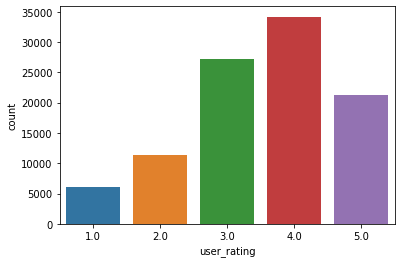

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the data
sns.countplot(x='user_rating', data=df)
plt.show()

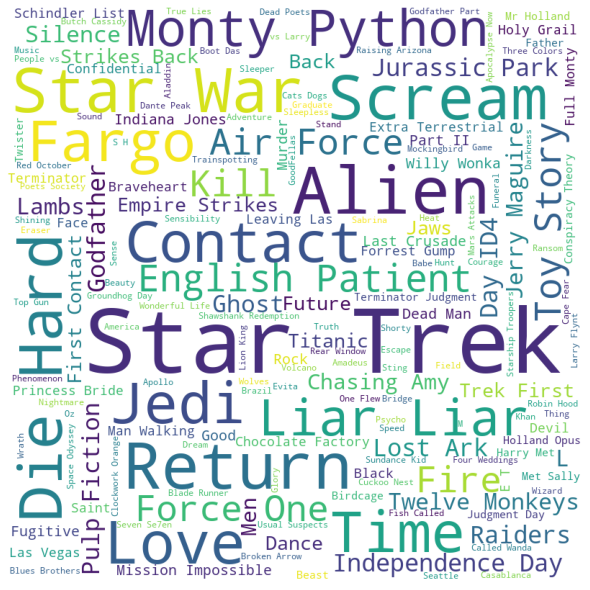

In [13]:
from wordcloud import WordCloud, STOPWORDS

titles = df['movie_title'].tolist()


stopwords = STOPWORDS
wordcloud = WordCloud(width=800, height=800, background_color="white", min_font_size=10).generate(' '.join(titles))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [14]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [15]:
print('Training data:')
print(train)

print('Testing data:')
print(test)

Training data:
<TakeDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>
Testing data:
<TakeDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'user_rating': TensorSpec(shape=(), dtype=tf.float32, name=None)}>


In [16]:
movie_titles = ratings.batch(100_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(100_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [17]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [19]:
task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [20]:
class MoviePredictorModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      # Loss model changed from MeanSquaredError
      loss = tf.keras.losses.MeanAbsoluteError(),
      # Metrics model changed from RootMeanSquaredError
      metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

# Adam optimizer

In [44]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = MoviePredictorModel()
# Define the early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [71]:
# Import the mean_absolute_percentage_error function from scikit-learn
from sklearn.metrics import mean_absolute_percentage_error

def mean_absolute_percentage_error_tf(y_true, y_pred):
    y_true, y_pred = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

In [89]:
# Compile model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics=[mean_absolute_percentage_error_tf])

# Fit the model
history = model.fit(
    cached_train,
    validation_data=cached_test,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
10/10 [==============================] - 2s 65ms/step - mean_absolute_percentage_error: 30.9974 - loss: 0.8540 - regularization_loss: 0.0000e+00 - total_loss: 0.8540 - val_mean_absolute_percentage_error: 34.0329 - val_loss: 0.8451 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8451
Epoch 2/10
10/10 [==============================] - 1s 53ms/step - mean_absolute_percentage_error: 26.2642 - loss: 0.6721 - regularization_loss: 0.0000e+00 - total_loss: 0.6721 - val_mean_absolute_percentage_error: 31.1118 - val_loss: 0.7508 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.7508
Epoch 3/10
10/10 [==============================] - 1s 92ms/step - mean_absolute_percentage_error: 24.7034 - loss: 0.6233 - regularization_loss: 0.0000e+00 - total_loss: 0.6233 - val_mean_absolute_percentage_error: 30.0183 - val_loss: 0.7509 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.7509
Epoch 4/10
10/10 [==============================] - 1s 95ms/step - mean_absolute_perc

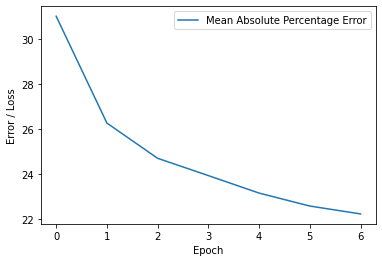

In [92]:
# Plot the mean absolute percentage error and total loss
plt.plot(history.history['mean_absolute_percentage_error'], label='Mean Absolute Percentage Error')
# plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Error / Loss')
plt.legend()
plt.show()

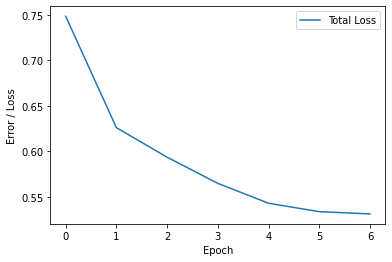

In [91]:
# Plot the mean absolute percentage error and total loss
plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Error / Loss')
plt.legend()
plt.show()

In [85]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 21ms/step - mean_absolute_percentage_error: 29.8067 - loss: 0.7363 - regularization_loss: 0.0000e+00 - total_loss: 0.7363


{'mean_absolute_percentage_error': 29.80670738220215,
 'loss': 0.737328052520752,
 'regularization_loss': 0,
 'total_loss': 0.737328052520752}

# Model Testing

In [108]:
# Show a random list of movies rated by user 42
user = df[df['user_id'] == 42]
user_random = user.sample(n=min(10, len(user)), random_state=5)
print(user_random)

                               movie_title  user_id  user_rating
51816                Cool Hand Luke (1967)       42          5.0
34779                   With Honors (1994)       42          4.0
33898                 Jurassic Park (1993)       42          4.0
80462              Grumpier Old Men (1995)       42          4.0
31806         Up Close and Personal (1996)       42          4.0
53476            Return of the Jedi (1983)       42          5.0
46576  Mr. Smith Goes to Washington (1939)       42          4.0
1255        While You Were Sleeping (1995)       42          4.0
26851         To Kill a Mockingbird (1962)       42          4.0
72441                     Liar Liar (1997)       42          4.0


In [109]:
test_ratings = {}
test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"]
user_id = "42"
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model({
      "user_id": np.array(["user_id"]),
      "movie_title": np.array([movie_title])
  })

print(f"Predicted ratings for user {user_id}:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

Predicted ratings for user 42:
M*A*S*H (1970): [[3.6972456]]
Dances with Wolves (1990): [[3.3670554]]
Speed (1994): [[3.136468]]


In [110]:
tf.saved_model.save(model, "export")

In [56]:
  # extract movie titles from the dataset
  movies = ratings.map(lambda x: x["movie_title"])
  movies = set([str(x.numpy()) for x in movies])

In [57]:
# loaded = tf.saved_model.load("export")


# import random
# import pandas as pd

# ratings_pred = {}
# user_pred = 33
# ifGenerate = input("Generate a list of movies to try? (Y/N): ")


# if (ifGenerate == "y"):
#   # Generate a list of random movie titles
#   random_movies = random.sample(movies, 5)
#   # Print the random movies
#   print("Here are some random movies for you to try:")
#   for movie in random_movies:
#     print("- " + movie)


# movie_title_pred = input("Enter the movie to predict ratings for: ")
# ratings_pred = model({
#       "user_id": ["42"],
#       "movie_title": [movie_title_pred]
#   })


# loaded({"user_id": np.array(["42"]), "movie_title": [movie_title_pred]}).numpy()

Generate a list of movies to try? (Y/N): y
Here are some random movies for you to try:
- b'Kull the Conqueror (1997)'
- b'Roman Holiday (1953)'
- b'Excess Baggage (1997)'
- b'Gandhi (1982)'
- b'Orlando (1993)'
Enter the movie to predict ratings for: a


AttributeError: ignored